# Comparison of Different Approximations for Transmon Readout

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"
save_figs = True

In [5]:
# Meta params for plots
resolution = 141

scan_range = (5.95, 6.09)

simulation_steps = 2001

# Setup Qubit, Resonator and Coupling
n_cutoff    = 15
EJ          = 18     * 2 * np.pi # h GHz
EC          = EJ / 50

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.130 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.020
driving_time           = (0, 50)
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)

driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

In [6]:
### Tools for plotting
def plot_curves_from_result_dictionairy(dict_with_results, ax):
    
    for i, results in dict_with_results.items():
        last_states_in_resonator = [result.states[-1].ptrace(1) for result in results]
        expectation_value_of_occupation = qutip.expect(a_dag * a, last_states_in_resonator)
        ax.plot(driving_frequencies_to_scan / (2 * np.pi), expectation_value_of_occupation, label = f"$|{i}\\rangle$")
    
    ax

    return ax

## Two Level Qubit

In [7]:
qubit_states = 2

# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

### Simulation for the Full Hamiltonian
Non interacting:  
$H_0 = \omega_r a^\dagger a + \sum_k \omega_k \ket{k}\bra{k}$  

Interacting:  
$H_1 = \sum_{ij} g_{ij} \ket{i}\bra{j}(a + a^\dagger)$

Driving:  
$H_d = 2i  \epsilon_d \sin(\omega_d t) (a^\dagger - a)$

In [8]:
from qutip import tensor, basis
from tqdm import tqdm

### The full Hamiltonian consists of:
# H0 - simple, non interacting terms
H_0 = tensor(H_qubit, qutip.qeye(resonator_states)) + tensor(qutip.qeye(qubit_states), resonator_frequency * a_dag * a)

# H1 - coupling between qubit and resonator - Jaynes Cumming
H_1 = coupling_strength * tensor(jump_matrix, a_dag + a)

# H2 - Driving of the resonator
H_d_matrix = 2j * tensor(qutip.qeye(qubit_states), a_dag - a)
H_d        = [H_d_matrix, drive_function] 

### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations
# Frequencies to try:


# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}


### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        current_result = mesolve(
            [H_0, H_1, H_d],
            args = {"driving_frequency": driving_frequency},
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)


100%|██████████| 141/141 [04:14<00:00,  1.80s/it]


#### Plotting the results
 We're interested in the occupation of the resonator af driving it. We plot it from the following along with lines showing the expected dispersive shift. 

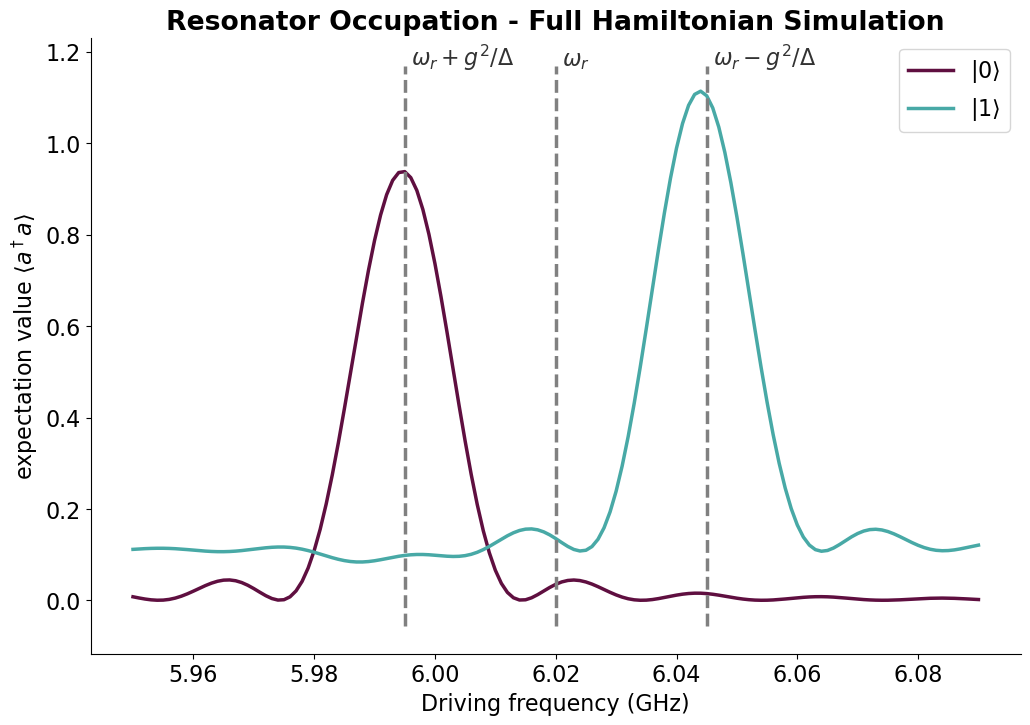

In [9]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

dispersive_shift_approx = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)
omega_r_plus = (resonator_frequency + dispersive_shift_approx.real) / (2 * np.pi) 
omega_r_minus = (resonator_frequency - dispersive_shift_approx.real) / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .001, limits[1], "$\omega_r$", alpha = 0.8)

ax.vlines(omega_r_plus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_plus + .001, limits[1], "$\omega_r - g^2/\Delta$", alpha = 0.8)

ax.vlines(omega_r_minus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_minus + .001, limits[1], "$\omega_r + g^2/\Delta$", alpha = 0.8)

# Write text on it
ax.legend()
ax.set(
    title = "Resonator Occupation - Full Hamiltonian Simulation",
    xlabel = "Driving frequency (GHz)",
    ylabel = "expectation value $\\langle a^\\dagger a \\rangle$"
);

if save_figs:
    fig.savefig(f"{save_path}/2State_Full.pdf")

### Rotating Wave Jaynes-Cummings Hamiltonian
Non interacting:  
$H_0 = \omega_r a^\dagger a + \sum_k \omega_k \ket{k}\bra{k}$  

Interacting:  
$H_1 = g (\ket{1}\bra{0}a + \ket{0}\bra{1}a^\dagger)$

Driving:  
$H_d = 2i  \epsilon_d  (a^\dagger - a )% \sin(\omega_d t) (a^\dagger - a)$

In [10]:
from qutip import tensor, basis, create, destroy
from tqdm import tqdm

### The full Hamiltonian consists of:
# H0 - simple, non interacting terms
H_0 = tensor(H_qubit, qutip.qeye(resonator_states)) + tensor(qutip.qeye(qubit_states), resonator_frequency * a_dag * a)

# H1 - coupling between qubit and resonator - Jaynes Cumming
state_overlap = abs(jump_matrix[0, 1])
H_1 = state_overlap * coupling_strength * (tensor(destroy(2), a_dag) + tensor(create(2), a))

# H2 - Driving of the resonator
H_d_matrix = 2j * tensor(qutip.qeye(qubit_states), a_dag - a)
H_d        = [H_d_matrix, drive_function] 

### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations

# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}


### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        current_result = mesolve(
            [H_0, H_1, H_d],
            args = {"driving_frequency": driving_frequency},
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)

if save_figs:
    fig.savefig(f"{save_path}/2State_RWA.pdf")

100%|██████████| 141/141 [04:30<00:00,  1.92s/it]


#### Plotting the results
 We're interested in the occupation of the resonator af driving it. We plot it from the following along with lines showing the expected dispersive shift. 

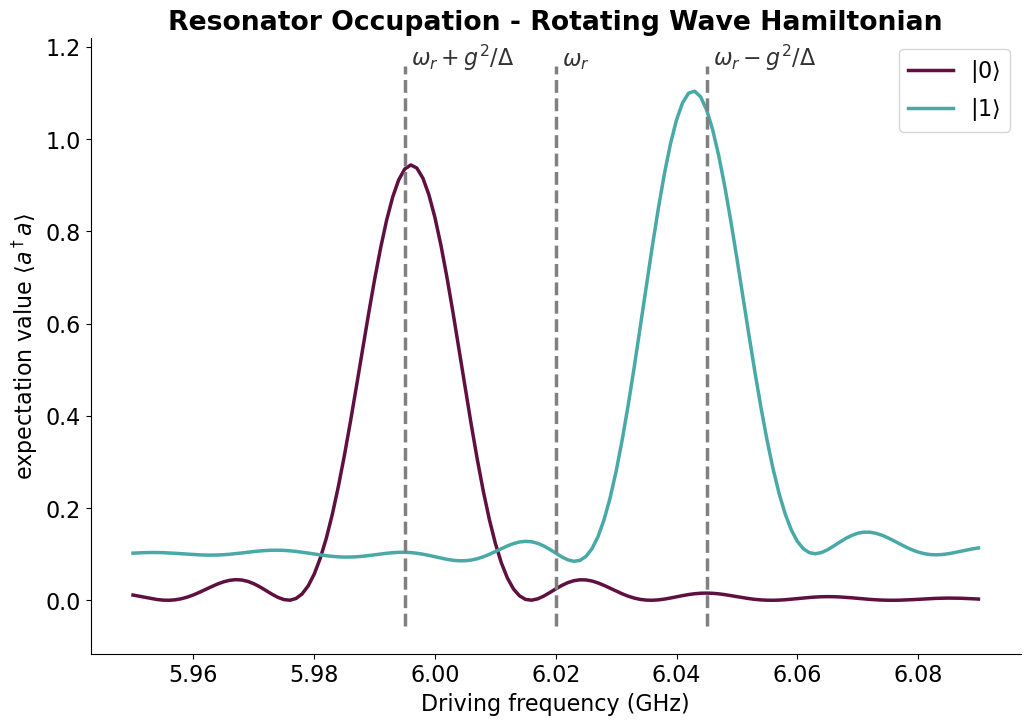

In [11]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

dispersive_shift_approx = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)
omega_r_plus = (resonator_frequency + dispersive_shift_approx.real) / (2 * np.pi) 
omega_r_minus = (resonator_frequency - dispersive_shift_approx.real) / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .001, limits[1], "$\omega_r$", alpha = 0.8)

ax.vlines(omega_r_plus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_plus + .001, limits[1], "$\omega_r - g^2/\Delta$", alpha = 0.8)

ax.vlines(omega_r_minus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_minus + .001, limits[1], "$\omega_r + g^2/\Delta$", alpha = 0.8)

# Write text on it
ax.legend()
ax.set(
    title = "Resonator Occupation - Rotating Wave Hamiltonian",
    xlabel = "Driving frequency (GHz)",
    ylabel = "expectation value $\\langle a^\\dagger a \\rangle$"
);

### RWA and dispersive limit
Here the Hamiltonian comes into a time-independent form:  
$H = \Omega a^\dagger a + \frac{\chi}{2} a^\dagger a \sigma_z + \epsilon (a + a^\dagger)$


In [12]:
# Function to get the Hamiltonian at a specific frequency
def H_dispersive(args):
    omega = resonator_frequency - args["driving_frequency"]
    chi   = abs(coupling_strength * state_overlap) ** 2 / (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

    H_reso  = omega * tensor(qutip.qeye(2), a_dag * a)
    H_int   = chi * tensor(qutip.sigmaz(), a_dag * a)
    H_drive = drive_amplitude * tensor(qutip.qeye(2), a_dag + a)  

    return H_reso + H_int + H_drive

### The intitial states to consider
initial_states = [basis([qubit_states, resonator_states], [i, 0]) for i in range(qubit_states)]


### Setup for simulations
# Dictionairy to store results
dict_for_results = {i: [] for i in range(qubit_states)}

### Do the simulations
from qutip import mesolve
for driving_frequency in tqdm(driving_frequencies_to_scan):
    for i, initial_state in enumerate(initial_states): 
        H = H_dispersive({"driving_frequency": driving_frequency})
        current_result = mesolve(
            H,
            rho0 = initial_state,
            tlist = np.linspace(*driving_time, simulation_steps),
        )
        
        # Append results
        dict_for_results[i].append(current_result)


100%|██████████| 141/141 [00:23<00:00,  5.99it/s]


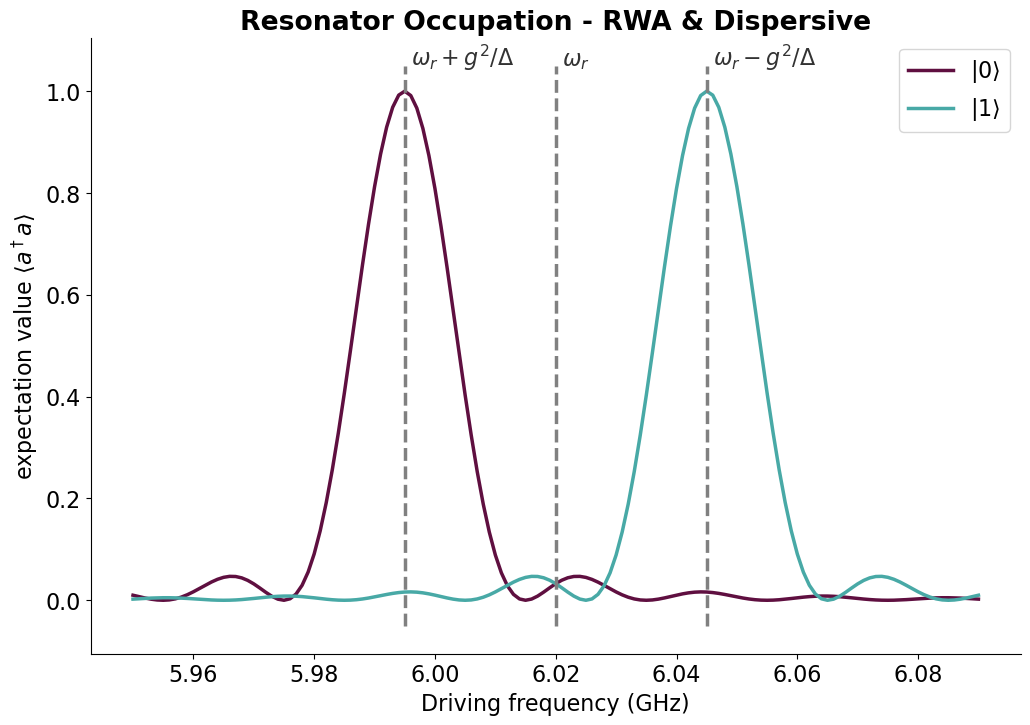

In [13]:
# Setup plot
fig, ax = plt.subplots()
ax = plot_curves_from_result_dictionairy(dict_for_results, ax)

# Plot different lines for considerations
limits = ax.get_ylim()

dispersive_shift_approx = coupling_strength**2 * abs(jump_matrix[0, 1]) ** 2/ (resonator_frequency - H_qubit[1, 1] + H_qubit[0, 0])

omega_r = resonator_frequency / (2 * np.pi)
omega_r_plus = (resonator_frequency + dispersive_shift_approx.real) / (2 * np.pi) 
omega_r_minus = (resonator_frequency - dispersive_shift_approx.real) / (2 * np.pi)

ax.vlines(omega_r, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r + .001, limits[1], "$\omega_r$", alpha = 0.8)

ax.vlines(omega_r_plus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_plus + .001, limits[1], "$\omega_r - g^2/\Delta$", alpha = 0.8)

ax.vlines(omega_r_minus, *limits, linestyles = "dashed", color = "gray")
ax.text(omega_r_minus + .001, limits[1], "$\omega_r + g^2/\Delta$", alpha = 0.8)

# Write text on it
ax.legend()
ax.set(
    title = "Resonator Occupation - RWA & Dispersive",
    xlabel = "Driving frequency (GHz)",
    ylabel = "expectation value $\\langle a^\\dagger a \\rangle$"
);

if save_figs:
    fig.savefig(f"{save_path}/2State_Dispersive_RWA.pdf")